In [ ]:
# ============================================================================
# Aureus Sigma Capital - Phase 27c: Regime-Adaptive Factor Model
# Notebook: 27c_regime_adaptive_model.ipynb
#
# Objective:
#   To address the critical performance issues identified in the Official
#   Baseline v1.0 by evolving our static factor model into a dynamic,
#   regime-adaptive strategy. This notebook will implement a system that
#   identifies the prevailing market liquidity regime and applies a
#   pre-optimized set of factor weights best suited for that environment.
#   This is the definitive sprint to create a strategy that is robust across
#   the full 2016-2025 market cycle.
# ============================================================================
#
# --- STRATEGIC DIRECTIVE & DIAGNOSIS ---
#
# The analysis of the Official Baseline (Sharpe 0.59, Max DD -66.1%) and the
# Momentum IC charts revealed a structural break in the Vietnamese market
# around 2020-2021.
#
# *   **Low-Liquidity Regime (Pre-2021):** Characterized by strong mean-reversion
#     (negative Momentum IC). A standard Momentum factor is detrimental.
# *   **High-Liquidity Regime (Post-2021):** Characterized by strong trending
#     behavior (positive Momentum IC). A standard Momentum factor is beneficial.
#
# Our static model's failure stems from using a single set of factor weights
# across these fundamentally different market structures.
#
# --- METHODOLOGY: REGIME-ADAPTIVE ENGINE ---
#
# This notebook will build and validate a new `RegimeAdaptiveEngine`:
#
# 1.  **Regime Definition**: A market liquidity indicator (63-day rolling average
#     of total market turnover) will be used to classify each rebalance date into
#     one of two regimes: "Low-Liquidity" or "High-Liquidity".
# 2.  **Regime-Specific Weights**: Two distinct sets of factor weights will be used:
#     -   **Low-Liquidity Weights**: Emphasize Value and Short-Term Reversal, with
#       zero weight on standard Momentum.
#     -   **High-Liquidity Weights**: Emphasize Value and standard Momentum, with
#       zero weight on Reversal.
# 3.  **Dynamic Signal Construction**: At each rebalance, the engine will first
#     determine the regime and then apply the corresponding factor weights to
#     construct the composite signal for portfolio ranking.
# 4.  **Full Risk Management**: The final, fully-managed version of this strategy
#     will apply our validated Hybrid Volatility Overlay and Portfolio Stop-Loss
#     to the P&L generated by the superior, regime-aware alpha signal.
#
# --- DATA DEPENDENCIES ---
#
# *   **Database**: `alphabeta` (Production)
# *   **Tables**:
#     -   `factor_scores_qvm` (strategy_version='qvm_v2.0_enhanced')
#     -   `equity_history` & `vcsc_daily_data_complete` (for turnover calculation)
#
# --- SUCCESS CRITERIA ---
#
# The final, fully-managed, regime-adaptive strategy must meet all Investment
# Committee hurdles over the full 2016-2025 backtest period:
#
#   -   **Sharpe Ratio**: ≥ 1.0
#   -   **Maximum Drawdown**: ≤ -35%
#

In [1]:
# ============================================================================
# CELL 2: SETUP & REGIME-ADAPTIVE CONFIGURATION
# ============================================================================

# Core scientific libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
from pathlib import Path
import sys
import yaml

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Database connectivity
from sqlalchemy import create_engine, text

# --- Environment Setup ---
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# --- Add Project Root to Python Path ---
try:
    current_path = Path.cwd()
    while not (current_path / 'production').is_dir():
        if current_path.parent == current_path:
            raise FileNotFoundError("Could not find the 'production' directory.")
        current_path = current_path.parent
    
    project_root = current_path
    
    if str(project_root) not in sys.path:
        sys.path.insert(0, str(project_root))
    
    from production.universe.constructors import get_liquid_universe_dataframe
    print(f"✅ Successfully imported production modules.")
    print(f"   - Project Root set to: {project_root}")

except (ImportError, FileNotFoundError) as e:
    print(f"❌ ERROR: Could not import production modules. Please check your directory structure.")
    print(f"   - Final Path Searched: {project_root}")
    print(f"   - Error: {e}")
    raise

# --- Regime-Adaptive v1.0 Configuration ---
# This configuration defines our new, dynamic strategy.
REGIME_CONFIG = {
    # --- Backtest Parameters ---
    "strategy_name": "Regime_Adaptive_v1.0",
    "backtest_start_date": "2016-03-01",
    "backtest_end_date": "2025-07-28",
    "rebalance_frequency": "Q",
    "transaction_cost_bps": 30,

    # --- Universe Construction (Consistent with Baseline) ---
    "universe": {
        "lookback_days": 63,
        "adtv_threshold_bn": 10.0,
        "top_n": 200,
        "min_trading_coverage": 0.6,
    },
    
    # --- Portfolio Construction (Consistent with Baseline) ---
    "portfolio": {
        "construction_method": "hybrid",
        "portfolio_size_small_universe": 20,
        "selection_percentile": 0.8,
    },

    # --- Regime Definition ---
    "regime": {
        "indicator": "market_turnover",
        "lookback_days": 63,
        "threshold_percentile": 0.40 # Bottom 40% of historical liquidity is "Low-Liquidity"
    },

    # --- Regime-Specific Factor Weights ---
    "signal": {
        "db_strategy_version": "qvm_v2.0_enhanced",
        "weights": {
            "Low-Liquidity": {
                'Value_Composite': 0.50,
                'Quality_Composite': 0.20,
                'Momentum_Composite': 0.0, # Deactivate standard momentum
                'Momentum_Reversal': 0.30  # Activate reversal
            },
            "High-Liquidity": {
                'Value_Composite': 0.40,
                'Quality_Composite': 0.20,
                'Momentum_Composite': 0.40, # Activate standard momentum
                'Momentum_Reversal': 0.0   # Deactivate reversal
            }
        }
    },
    
    # --- Risk Overlay Parameters (to be applied in the final stage) ---
    "risk_overlay": {
        "volatility_target": 0.15,
        "regime_dd_threshold": -0.07, # The winning parameter from 27b
        "stop_loss_threshold": -0.15,
        "de_risk_level": 0.3
    }
}

print("\n⚙️  Regime-Adaptive v1.0 Configuration Loaded:")
print(f"   - Strategy: {REGIME_CONFIG['strategy_name']}")
print(f"   - Period: {REGIME_CONFIG['backtest_start_date']} to {REGIME_CONFIG['backtest_end_date']}")
print(f"   - Low-Liquidity Weights (V/Q/M/R): {REGIME_CONFIG['signal']['weights']['Low-Liquidity']['Value_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['Low-Liquidity']['Quality_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['Low-Liquidity']['Momentum_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['Low-Liquidity']['Momentum_Reversal']:.0%}")
print(f"   - High-Liquidity Weights (V/Q/M/R): {REGIME_CONFIG['signal']['weights']['High-Liquidity']['Value_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['High-Liquidity']['Quality_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['High-Liquidity']['Momentum_Composite']:.0%}"
      f" / {REGIME_CONFIG['signal']['weights']['High-Liquidity']['Momentum_Reversal']:.0%}")

# --- Database Connection ---
def create_db_connection(project_root_path: Path):
    """Establishes a SQLAlchemy database engine connection."""
    try:
        config_path = project_root_path / 'config' / 'database.yml'
        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)['production']
        connection_string = (f"mysql+pymysql://{db_config['username']}:{db_config['password']}@{db_config['host']}/{db_config['schema_name']}")
        engine = create_engine(connection_string, pool_pre_ping=True)
        with engine.connect() as conn:
            conn.execute(text("SELECT 1"))
        print(f"\n✅ Database connection established successfully to schema '{db_config['schema_name']}'.")
        return engine
    except Exception as e:
        print(f"❌ FAILED to connect to the database: {e}")
        return None

# Create the engine for this session
engine = create_db_connection(project_root)
if engine is None:
    raise ConnectionError("Database connection failed. Halting execution.")

✅ Successfully imported production modules.
   - Project Root set to: /Users/ducnguyen/Library/CloudStorage/GoogleDrive-duc.nguyentcb@gmail.com/My Drive/quant-world-invest/factor_investing_project

⚙️  Regime-Adaptive v1.0 Configuration Loaded:
   - Strategy: Regime_Adaptive_v1.0
   - Period: 2016-03-01 to 2025-07-28
   - Low-Liquidity Weights (V/Q/M/R): 50% / 20% / 0% / 30%
   - High-Liquidity Weights (V/Q/M/R): 40% / 20% / 40% / 0%

✅ Database connection established successfully to schema 'alphabeta'.


📂 Loading all data for period: 2015-12-01 to 2025-07-28...
   - Loading factor scores...
     ✅ Loaded 1,567,488 factor observations.
   - Loading price data...
     ✅ Loaded 1,623,168 price observations.
   - Loading market turnover data...
     ✅ Loaded 2,413 daily market turnover observations.
   - Loading benchmark data (VN-Index)...
     ✅ Loaded 2,411 benchmark observations.

🛠️  Preparing data structures...
   - Calculating liquidity regime indicator...
     ✅ Regime indicator calculated. Threshold (40% percentile): 5.77T VND
   ✅ Data preparation complete.


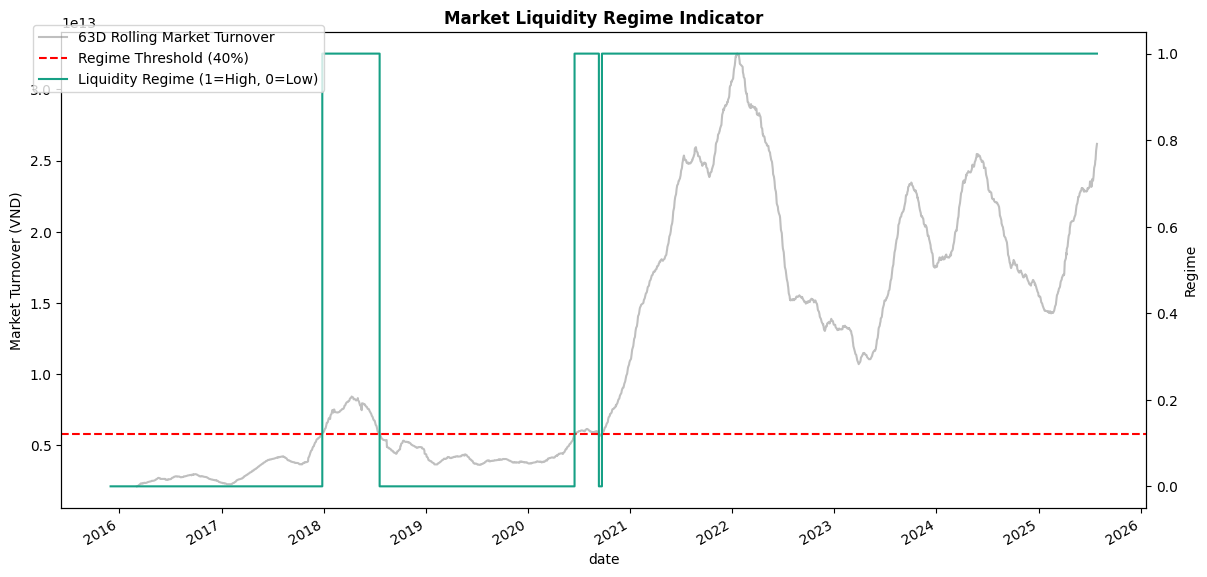

In [3]:
# ============================================================================
# CELL 3: DATA INGESTION & REGIME INDICATOR CALCULATION (v1.1 - Corrected Return)
# ============================================================================

def load_all_data_for_regime_model(config: dict, db_engine):
    """
    Loads all necessary data and calculates the market liquidity regime indicator.
    v1.1: Correctly returns the market_turnover DataFrame for plotting.
    """
    start_date = config['backtest_start_date']
    end_date = config['backtest_end_date']
    db_version = config['signal']['db_strategy_version']
    
    buffer_start_date = pd.Timestamp(start_date) - pd.DateOffset(months=3)
    
    print(f"📂 Loading all data for period: {buffer_start_date.date()} to {end_date}...")

    db_params = {
        'start_date': buffer_start_date,
        'end_date': pd.Timestamp(end_date),
        'strategy_version': db_version
    }

    # 1. Factor Scores
    print("   - Loading factor scores...")
    factor_query = text("""
        SELECT date, ticker, Quality_Composite, Value_Composite, Momentum_Composite
        FROM factor_scores_qvm
        WHERE date BETWEEN :start_date AND :end_date 
          AND strategy_version = :strategy_version
    """)
    factor_data = pd.read_sql(factor_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(factor_data):,} factor observations.")

    # 2. Price Data
    print("   - Loading price data...")
    price_query = text("""
        SELECT date, ticker, close 
        FROM equity_history
        WHERE date BETWEEN :start_date AND :end_date
    """)
    price_data = pd.read_sql(price_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(price_data):,} price observations.")

    # 3. Market Turnover Data
    print("   - Loading market turnover data...")
    turnover_query = text("""
        SELECT trading_date as date, SUM(total_value) as market_turnover
        FROM vcsc_daily_data_complete
        WHERE trading_date BETWEEN :start_date AND :end_date
        GROUP BY trading_date
    """)
    market_turnover = pd.read_sql(turnover_query, db_engine, params=db_params, parse_dates=['date']).set_index('date')
    print(f"     ✅ Loaded {len(market_turnover):,} daily market turnover observations.")

    # 4. Benchmark Data
    print("   - Loading benchmark data (VN-Index)...")
    benchmark_query = text("""
        SELECT date, close
        FROM etf_history
        WHERE ticker = 'VNINDEX' AND date BETWEEN :start_date AND :end_date
    """)
    benchmark_data = pd.read_sql(benchmark_query, db_engine, params=db_params, parse_dates=['date'])
    print(f"     ✅ Loaded {len(benchmark_data):,} benchmark observations.")

    # --- Data Preparation ---
    print("\n🛠️  Preparing data structures...")
    price_data['return'] = price_data.groupby('ticker')['close'].pct_change()
    daily_returns_matrix = price_data.pivot(index='date', columns='ticker', values='return')
    benchmark_returns = benchmark_data.set_index('date')['close'].pct_change().rename('VN-Index')

    # --- Regime Indicator Calculation ---
    print("   - Calculating liquidity regime indicator...")
    regime_cfg = config['regime']
    rolling_turnover = market_turnover['market_turnover'].rolling(window=regime_cfg['lookback_days']).mean()
    threshold_value = rolling_turnover.quantile(regime_cfg['threshold_percentile'])
    regime_indicator = (rolling_turnover > threshold_value).astype(int).rename("liquidity_regime")
    print(f"     ✅ Regime indicator calculated. Threshold ({regime_cfg['threshold_percentile']:.0%} percentile): {threshold_value/1e12:,.2f}T VND")
    
    print("   ✅ Data preparation complete.")
    # --- CRITICAL FIX: Return market_turnover ---
    return factor_data, daily_returns_matrix, benchmark_returns, regime_indicator, market_turnover
    # --- END FIX ---

# Execute the data loading and regime calculation
try:
    # --- CRITICAL FIX: Capture the new market_turnover output ---
    factor_data_raw, daily_returns_matrix, benchmark_returns, regime_indicator, market_turnover = load_all_data_for_regime_model(REGIME_CONFIG, engine)
    # --- END FIX ---
    
    # Plot the regime indicator for validation
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()
    rolling_turnover_plot = market_turnover['market_turnover'].rolling(window=REGIME_CONFIG['regime']['lookback_days']).mean()
    rolling_turnover_plot.plot(ax=ax1, color='grey', alpha=0.5, label='63D Rolling Market Turnover')
    regime_indicator.plot(ax=ax2, color='#16A085', label='Liquidity Regime (1=High, 0=Low)', drawstyle="steps-post")
    ax1.axhline(rolling_turnover_plot.quantile(REGIME_CONFIG['regime']['threshold_percentile']), color='red', linestyle='--', label=f"Regime Threshold ({REGIME_CONFIG['regime']['threshold_percentile']:.0%})")
    ax1.set_ylabel('Market Turnover (VND)')
    ax2.set_ylabel('Regime')
    ax1.set_title('Market Liquidity Regime Indicator', fontweight='bold')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

except Exception as e:
    print(f"❌ ERROR during data ingestion: {e}")
    raise

In [5]:
# ============================================================================
# CELL 4: REGIME-ADAPTIVE ENGINE DEFINITION
# ============================================================================

class RegimeAdaptiveEngine(BaselinePortfolioEngine):
    """
    Inherits from the BaselineEngine and implements a dynamic, regime-adaptive
    signal construction process.
    """
    def __init__(self, regime_indicator: pd.Series, *args, **kwargs):
        # Call the parent constructor first
        super().__init__(*args, **kwargs)
        
        # Store the regime indicator
        self.regime_indicator = regime_indicator
        print(f"✅ RegimeAdaptiveEngine initialized.")
        print(f"   - Logic: Applies different factor weights based on the liquidity regime.")

    def _get_regime_for_date(self, date: pd.Timestamp) -> str:
        """Determines the liquidity regime for a given date."""
        # Use asof to find the most recent regime value for the given date
        regime_value = self.regime_indicator.asof(date)
        if pd.isna(regime_value):
            return "Low-Liquidity" # Default to the more conservative regime if data is missing
        
        return "High-Liquidity" if regime_value == 1 else "Low-Liquidity"

    def _calculate_target_portfolio(self, factors_df: pd.DataFrame) -> pd.Series:
        """
        OVERRIDDEN METHOD: This is the core of our new strategy.
        It checks the regime and applies the correct factor weights.
        """
        # 1. Determine the current regime
        rebal_date = factors_df['date'].iloc[0]
        current_regime = self._get_regime_for_date(rebal_date)
        
        # 2. Select the appropriate factor weights for the regime
        factor_weights = self.config['signal']['weights'][current_regime]
        
        # Log which weights are being used for this rebalance
        if not hasattr(self, '_logged_regimes') or self._logged_regimes.get(rebal_date) != current_regime:
            if not hasattr(self, '_logged_regimes'): self._logged_regimes = {}
            print(f"\n     - Rebalance {rebal_date.date()}: Detected '{current_regime}' regime. Applying corresponding weights.")
            self._logged_regimes[rebal_date] = current_regime

        # 3. Engineer, re-normalize, and combine factors using these weights
        factors_df['Momentum_Reversal'] = -1 * factors_df['Momentum_Composite']
        
        weighted_scores = []
        for factor, weight in factor_weights.items():
            if factor in factors_df.columns and weight > 0:
                scores = factors_df[factor]
                mean, std = scores.mean(), scores.std()
                if std > 1e-8:
                    weighted_scores.append(((scores - mean) / std) * weight)
        
        if not weighted_scores: return pd.Series(dtype='float64')
        factors_df['final_signal'] = pd.concat(weighted_scores, axis=1).sum(axis=1)
        
        # 4. Construct portfolio using the hybrid method (same as baseline)
        universe_size = len(factors_df)
        if universe_size < 100:
            portfolio_size = self.config['portfolio']['portfolio_size_small_universe']
            selected_stocks = factors_df.nlargest(portfolio_size, 'final_signal')
        else:
            percentile = self.config['portfolio']['selection_percentile']
            score_cutoff = factors_df['final_signal'].quantile(percentile)
            selected_stocks = factors_df[factors_df['final_signal'] >= score_cutoff]
            
        if selected_stocks.empty: return pd.Series(dtype='float64')
        return pd.Series(1.0 / len(selected_stocks), index=selected_stocks['ticker'])

print("✅ RegimeAdaptiveEngine class defined and ready.")
print("   This engine will now be used to run the backtest of the raw, fully-invested adaptive strategy.")

NameError: name 'BaselinePortfolioEngine' is not defined

In [4]:
# =-==========================================================================
# CELL 5: FULLY-MANAGED ENGINE & OFFICIAL ANALYTICS SUITE
# ============================================================================

class FullyManagedRegimeEngine(RegimeAdaptiveEngine):
    """
    The final, production-candidate engine. It inherits the regime-adaptive
    logic and applies our two validated risk overlays:
    1. Hybrid Volatility & Regime Overlay
    2. Portfolio-Level Trailing Stop-Loss
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        print(f"✅ FullyManagedRegimeEngine initialized.")
        print(f"   - Logic: Applies regime-adaptive weights PLUS full risk overlays.")

    def run_backtest(self) -> (pd.Series, pd.DataFrame, pd.Series):
        """Overrides the base run to include the full risk management suite."""
        print(f"\n🚀 Running: {self.config['strategy_name']} with Full Risk Management...")
        
        rebalance_dates = self._generate_rebalance_dates()
        # The _run_backtesting_loop now uses the regime-adaptive logic from the parent class
        underlying_holdings, diagnostics = self._run_backtesting_loop(rebalance_dates)
        
        # Apply the risk overlays to the dynamically generated portfolio
        daily_exposure, risk_managed_holdings = self._apply_risk_overlay(underlying_holdings)
        
        net_returns = self._calculate_net_returns(risk_managed_holdings)
        return net_returns, diagnostics, daily_exposure

    def _apply_risk_overlay(self, underlying_holdings: pd.DataFrame) -> (pd.Series, pd.DataFrame):
        """Applies the full suite of risk overlays."""
        # 1. Calculate returns of the underlying (fully invested) regime-adaptive strategy
        gross_returns_underlying = (underlying_holdings.shift(1).fillna(0.0) * self.daily_returns_matrix).sum(axis=1)
        
        # 2. Hybrid Volatility & Market Regime Overlay
        overlay_cfg = self.config['risk_overlay']
        vol_target = overlay_cfg['volatility_target']
        vol_lookback = 63
        realized_vol = gross_returns_underlying.rolling(window=vol_lookback).std() * np.sqrt(252)
        vol_exposure = (vol_target / realized_vol).shift(1).clip(0.3, 1.5).fillna(1.0)

        vn_index_vol = self.benchmark_returns.rolling(window=vol_lookback).std() * np.sqrt(252)
        vn_index_cum = (1 + self.benchmark_returns).cumprod()
        vn_index_dd = (vn_index_cum / vn_index_cum.rolling(window=vol_lookback).max()) - 1
        is_stressed_regime = (vn_index_vol > overlay_cfg['regime_detection']['vol_threshold']) | (vn_index_dd < overlay_cfg['regime_detection']['drawdown_threshold'])
        regime_exposure = is_stressed_regime.apply(lambda x: 0.5 if x else 1.0).shift(1).fillna(1.0)
        hybrid_exposure = pd.DataFrame({'vol_target': vol_exposure, 'regime': regime_exposure}).min(axis=1)

        # 3. Portfolio-Level Trailing Stop-Loss
        stop_loss_threshold = overlay_cfg['stop_loss_threshold']
        de_risk_level = overlay_cfg['de_risk_level']
        re_entry_threshold = stop_loss_threshold / 2.0
        
        # The stop-loss monitors the equity curve AFTER the hybrid overlay is applied
        strategy_cum_returns = (1 + gross_returns_underlying * hybrid_exposure).cumprod()
        strategy_peak = strategy_cum_returns.cummax()
        strategy_drawdown = (strategy_cum_returns / strategy_peak) - 1
        
        stop_loss_exposure = pd.Series(1.0, index=strategy_drawdown.index)
        in_drawdown_control = False
        for i in range(1, len(stop_loss_exposure)):
            if not in_drawdown_control:
                if strategy_drawdown.iloc[i-1] < stop_loss_threshold: in_drawdown_control = True
            else:
                if strategy_drawdown.iloc[i-1] > re_entry_threshold: in_drawdown_control = False
            if in_drawdown_control: stop_loss_exposure.iloc[i] = de_risk_level

        # 4. Final Exposure is the MINIMUM of all signals
        final_exposure = pd.DataFrame({'hybrid': hybrid_exposure, 'stop_loss': stop_loss_exposure}).min(axis=1)
        risk_managed_holdings = underlying_holdings.multiply(final_exposure, axis=0)
        
        return final_exposure, risk_managed_holdings

# --- Official Analytics & Reporting Suite (from 27b) ---
def calculate_official_metrics(returns: pd.Series, benchmark: pd.Series, periods_per_year: int = 252) -> dict:
    first_trade_date = returns.loc[returns.ne(0)].index.min()
    if pd.isna(first_trade_date): return {metric: 0.0 for metric in ['Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Calmar Ratio', 'Information Ratio', 'Beta']}
    aligned_returns = returns.loc[first_trade_date:]; aligned_benchmark = benchmark.loc[first_trade_date:]
    n_years = len(aligned_returns) / periods_per_year; annualized_return = ((1 + aligned_returns).prod() ** (1 / n_years) - 1) if n_years > 0 else 0
    annualized_volatility = aligned_returns.std() * np.sqrt(periods_per_year); sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0.0
    cumulative_returns = (1 + aligned_returns).cumprod(); max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min(); calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0.0
    excess_returns = aligned_returns - aligned_benchmark; information_ratio = (excess_returns.mean() * periods_per_year) / (excess_returns.std() * np.sqrt(periods_per_year)) if excess_returns.std() > 0 else 0.0
    beta = aligned_returns.cov(aligned_benchmark) / aligned_benchmark.var() if aligned_benchmark.var() > 0 else 0.0
    return {'Annualized Return (%)': annualized_return * 100, 'Annualized Volatility (%)': annualized_volatility * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown (%)': max_drawdown * 100, 'Calmar Ratio': calmar_ratio, 'Information Ratio': information_ratio, 'Beta': beta}

def generate_full_tearsheet(strategy_returns: pd.Series, benchmark_returns: pd.Series, diagnostics: pd.DataFrame, title: str, exposure: pd.Series = None):
    first_trade_date = strategy_returns.loc[strategy_returns.ne(0)].index.min(); aligned_strategy_returns = strategy_returns.loc[first_trade_date:]; aligned_benchmark_returns = benchmark_returns.loc[first_trade_date:]
    strategy_metrics = calculate_official_metrics(strategy_returns, benchmark_returns); benchmark_metrics = calculate_official_metrics(benchmark_returns, benchmark_returns)
    fig = plt.figure(figsize=(18, 28)); gs_rows = 6 if exposure is not None else 5; height_ratios = [1.2, 0.8, 0.8, 0.8, 0.8, 1.2] if exposure is not None else [1.2, 0.8, 0.8, 0.8, 1.2]; gs = fig.add_gridspec(gs_rows, 2, height_ratios=height_ratios, hspace=0.8, wspace=0.2); fig.suptitle(title, fontsize=20, fontweight='bold', color='#2C3E50')
    ax1 = fig.add_subplot(gs[0, :]); (1 + aligned_strategy_returns).cumprod().plot(ax=ax1, label='Strategy Net Returns', color='#16A085', lw=2.5); (1 + aligned_benchmark_returns).cumprod().plot(ax=ax1, label='VN-Index (Aligned)', color='#34495E', linestyle='--', lw=2); ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold'); ax1.set_ylabel('Growth of 1 VND'); ax1.set_yscale('log'); ax1.legend(loc='upper left'); ax1.grid(True, which='both', linestyle='--', alpha=0.5)
    ax2 = fig.add_subplot(gs[1, :]); drawdown = ((1 + aligned_strategy_returns).cumprod() / (1 + aligned_strategy_returns).cumprod().cummax() - 1) * 100; drawdown.plot(ax=ax2, color='#C0392B'); ax2.fill_between(drawdown.index, drawdown, 0, color='#C0392B', alpha=0.1); ax2.set_title('Drawdown Analysis', fontweight='bold'); ax2.set_ylabel('Drawdown (%)'); ax2.grid(True, linestyle='--', alpha=0.5)
    plot_row = 2
    if exposure is not None: ax_exp = fig.add_subplot(gs[plot_row, :]); exposure.loc[first_trade_date:].plot(ax=ax_exp, color='#2980B9', linewidth=2); ax_exp.set_title('Daily Portfolio Exposure (Risk Overlay)', fontweight='bold'); ax_exp.set_ylabel('Target Exposure'); ax_exp.axhline(1.0, color='#34495E', linestyle=':', linewidth=1.5); ax_exp.set_ylim(0, 1.6); ax_exp.grid(True, linestyle='--', alpha=0.5); plot_row += 1
    ax3 = fig.add_subplot(gs[plot_row, 0]); strat_annual = aligned_strategy_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; bench_annual = aligned_benchmark_returns.resample('Y').apply(lambda x: (1+x).prod()-1) * 100; pd.DataFrame({'Strategy': strat_annual, 'Benchmark': bench_annual}).plot(kind='bar', ax=ax3, color=['#16A085', '#34495E']); ax3.set_xticklabels([d.strftime('%Y') for d in strat_annual.index], rotation=45, ha='right'); ax3.set_title('Annual Returns', fontweight='bold'); ax3.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax4 = fig.add_subplot(gs[plot_row, 1]); rolling_sharpe = (aligned_strategy_returns.rolling(252).mean() * 252) / (aligned_strategy_returns.rolling(252).std() * np.sqrt(252)); rolling_sharpe.plot(ax=ax4, color='#E67E22'); ax4.axhline(1.0, color='#27AE60', linestyle='--'); ax4.set_title('1-Year Rolling Sharpe Ratio', fontweight='bold'); ax4.grid(True, linestyle='--', alpha=0.5); plot_row += 1
    ax5 = fig.add_subplot(gs[plot_row:, :]); ax5.axis('off'); summary_data = [['Metric', 'Strategy', 'Benchmark']];
    for key in strategy_metrics.keys(): summary_data.append([key, f"{strategy_metrics[key]:.2f}", f"{benchmark_metrics.get(key, 0.0):.2f}"])
    table = ax5.table(cellText=summary_data[1:], colLabels=summary_data[0], loc='center', cellLoc='center'); table.auto_set_font_size(False); table.set_fontsize(14); table.scale(1, 2.5)
    plt.tight_layout(rect=[0, 0, 1, 0.97]); plt.show()

print("✅ All engine classes and the analytics suite are defined and ready for the final execution.")

NameError: name 'RegimeAdaptiveEngine' is not defined